In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# Data Loading and Preprocessing
data = pd.read_csv('/content/MLE-Assignment.csv')
X_id = data.drop(['vomitoxin_ppb'], axis=1)
X = data.drop(['hsi_id', 'vomitoxin_ppb'], axis=1)
y = data['vomitoxin_ppb']/1e3

# Handle missing values (if any) - replace with mean for now
X.fillna(X.mean(), inplace=True)

# Normalize features using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

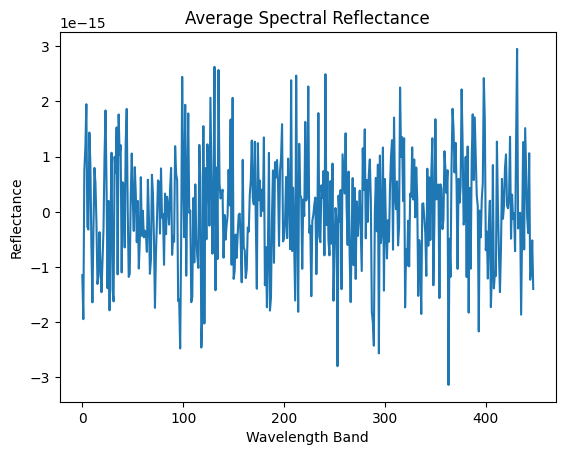

In [ ]:
# Plot the average spectral reflectance across all samples
plt.plot(np.mean(X, axis=0))
plt.title('Average Spectral Reflectance')
plt.xlabel('Wavelength Band')
plt.ylabel('Reflectance')
plt.show()  # To see the output, run the code.

In [ ]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# from sklearn.ensemble import HistGradientBoostingRegressor

# # Initialize and train the HistGradientBoostingRegressor
# hgb_regressor = HistGradientBoostingRegressor(max_iter=100, random_state=42) # You can adjust max_iter
# hgb_regressor.fit(X_train, y_train)

# # Make predictions on the validation set
# y_pred = hgb_regressor.predict(X_val)

# # Evaluate the model
# mse = mean_squared_error(y_val, y_pred)
# r2 = r2_score(y_val, y_pred)

# print(f"Mean Squared Error: {mse}")
# print(f"R-squared: {r2}")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size,
                 hidden_size1, hidden_size2,
                 output_size, dropout_rate=0.5):  # Add dropout_rate
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)  # Add dropout layer
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)  # Add dropout layer
        self.final = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)  # Apply dropout
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)  # Apply dropout
        out = self.final(out)
        return out

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32) # Reshape y_train
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1), dtype=torch.float32) # Reshape y_val

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Model parameters
input_size = X_train.shape[1]
hidden_size1 = 512
hidden_size2 = 512
output_size = 1
learning_rate = 1e-4
num_epochs = 50

# Initialize the model, loss function, and optimizer
model = MLP(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    train_loss = 0.0  # Initialize train_loss for the epoch

    # For calculating R2 on training set
    all_train_targets = []
    all_train_outputs = []

    for i, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)  # Accumulate train_loss

        # Store predictions and targets for R2 calculation
        all_train_targets.extend(targets.detach().cpu().numpy().flatten())
        all_train_outputs.extend(outputs.detach().cpu().numpy().flatten())

    epoch_train_loss = train_loss / len(train_loader.dataset)  # Average train_loss

    # Calculate metrics on training set
    train_mae = mean_absolute_error(all_train_targets, all_train_outputs)
    train_rmse = np.sqrt(mean_squared_error(all_train_targets, all_train_outputs))
    train_r2 = r2_score(all_train_targets, all_train_outputs)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, '
          f'Train MAE: {train_mae:.4f}, '
          f'Train RMSE: {train_rmse:.4f}, '
          f'Train R2: {train_r2:.4f}', end=", ")

    # Validation calculation within the epoch loop
    with torch.no_grad():
        model.eval()
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        y_pred = val_outputs.detach().cpu().numpy()  # Convert to NumPy array
        y_true = y_val_tensor.cpu().numpy()  # Convert to NumPy array

        # Calculate metrics on validation set
        val_mae = mean_absolute_error(y_true, y_pred)
        val_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        val_r2 = r2_score(y_true, y_pred)

        print(f'Validation Loss: {val_loss.item():.4f}, '
              f'Validation MAE: {val_mae:.4f}, '
              f'Validation RMSE: {val_rmse:.4f}, '
              f'Validation R2: {val_r2:.4f}')

Epoch [1/50], Train Loss: 152.1320, Train MAE: 3.0660, Train RMSE: 12.3342, Train R2: -0.0583, Validation Loss: 289.6736, Validation MAE: 4.2992, Validation RMSE: 17.0198, Validation R2: -0.0363
Epoch [2/50], Train Loss: 147.4887, Train MAE: 3.1185, Train RMSE: 12.1445, Train R2: -0.0260, Validation Loss: 281.0739, Validation MAE: 4.4311, Validation RMSE: 16.7653, Validation R2: -0.0055
Epoch [3/50], Train Loss: 143.3995, Train MAE: 3.2555, Train RMSE: 11.9750, Train R2: 0.0024, Validation Loss: 268.7731, Validation MAE: 4.5565, Validation RMSE: 16.3943, Validation R2: 0.0385
Epoch [4/50], Train Loss: 137.2464, Train MAE: 3.2702, Train RMSE: 11.7152, Train R2: 0.0452, Validation Loss: 255.3392, Validation MAE: 4.5655, Validation RMSE: 15.9793, Validation R2: 0.0866
Epoch [5/50], Train Loss: 129.8373, Train MAE: 3.2977, Train RMSE: 11.3946, Train R2: 0.0968, Validation Loss: 236.9226, Validation MAE: 4.5996, Validation RMSE: 15.3923, Validation R2: 0.1524
Epoch [6/50], Train Loss: 121.8

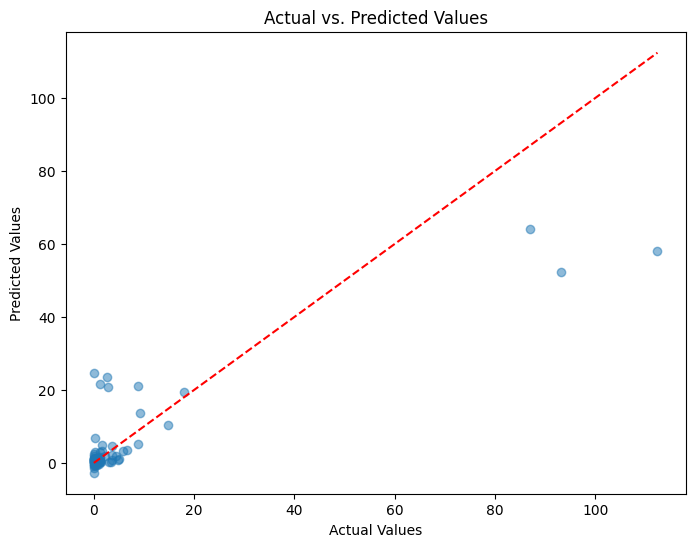

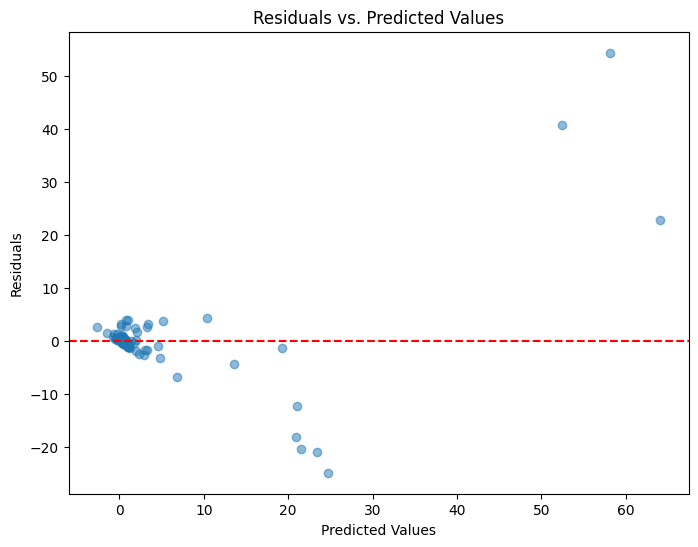

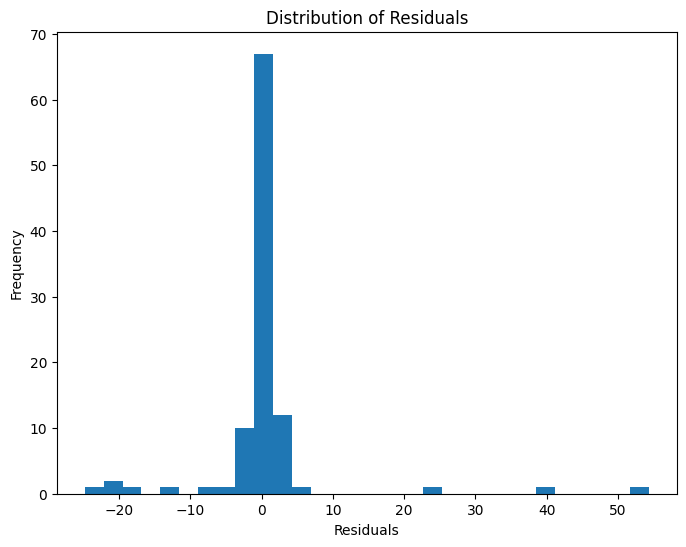

In [ ]:
# Plotting actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--') # Add a diagonal line
plt.show()


# Residual analysis
residuals = y_true - y_pred

# Plot residuals vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.show()

# Plot a histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size,
                 hidden_size1, hidden_size2, hidden_size3, hidden_size4,
                 output_size, dropout_rate=0.5):  # Add dropout_rate
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)  # Add dropout layer
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)  # Add dropout layer
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.bn3 = nn.BatchNorm1d(hidden_size3)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)  # Add dropout layer
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.bn4 = nn.BatchNorm1d(hidden_size4)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(dropout_rate)  # Add dropout layer
        self.final = nn.Linear(hidden_size4, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)  # Apply dropout
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)  # Apply dropout
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.dropout3(out)  # Apply dropout
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.dropout4(out)  # Apply dropout
        out = self.final(out)
        return out

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32) # Reshape y_train
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1), dtype=torch.float32) # Reshape y_val

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Model parameters
input_size = X_train.shape[1]
hidden_size1 = 2048
hidden_size2 = 2048
hidden_size3 = 2048
hidden_size4 = 2048
output_size = 1
learning_rate = 1e-4
num_epochs = 50

# Initialize the model, loss function, and optimizer
model = MLP(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    train_loss = 0.0  # Initialize train_loss for the epoch

    # For calculating R2 on training set
    all_train_targets = []
    all_train_outputs = []

    for i, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)  # Accumulate train_loss

        # Store predictions and targets for R2 calculation
        all_train_targets.extend(targets.detach().cpu().numpy().flatten())
        all_train_outputs.extend(outputs.detach().cpu().numpy().flatten())

    epoch_train_loss = train_loss / len(train_loader.dataset)  # Average train_loss

    # Calculate metrics on training set
    train_mae = mean_absolute_error(all_train_targets, all_train_outputs)
    train_rmse = np.sqrt(mean_squared_error(all_train_targets, all_train_outputs))
    train_r2 = r2_score(all_train_targets, all_train_outputs)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, '
          f'Train MAE: {train_mae:.4f}, '
          f'Train RMSE: {train_rmse:.4f}, '
          f'Train R2: {train_r2:.4f}', end=", ")

    # Validation calculation within the epoch loop
    with torch.no_grad():
        model.eval()
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        y_pred = val_outputs.detach().cpu().numpy()  # Convert to NumPy array
        y_true = y_val_tensor.cpu().numpy()  # Convert to NumPy array

        # Calculate metrics on validation set
        val_mae = mean_absolute_error(y_true, y_pred)
        val_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        val_r2 = r2_score(y_true, y_pred)

        print(f'Validation Loss: {val_loss.item():.4f}, '
              f'Validation MAE: {val_mae:.4f}, '
              f'Validation RMSE: {val_rmse:.4f}, '
              f'Validation R2: {val_r2:.4f}')

Epoch [1/50], Train Loss: 149.1487, Train MAE: 3.1560, Train RMSE: 12.2126, Train R2: -0.0376, Validation Loss: 281.1145, Validation MAE: 4.4740, Validation RMSE: 16.7665, Validation R2: -0.0057
Epoch [2/50], Train Loss: 139.8302, Train MAE: 3.7484, Train RMSE: 11.8250, Train R2: 0.0273, Validation Loss: 226.4560, Validation MAE: 4.6356, Validation RMSE: 15.0485, Validation R2: 0.1899
Epoch [3/50], Train Loss: 103.7748, Train MAE: 3.0129, Train RMSE: 10.1870, Train R2: 0.2781, Validation Loss: 119.6147, Validation MAE: 4.3875, Validation RMSE: 10.9368, Validation R2: 0.5721
Epoch [4/50], Train Loss: 85.7051, Train MAE: 3.1817, Train RMSE: 9.2577, Train R2: 0.4038, Validation Loss: 175.8647, Validation MAE: 3.4039, Validation RMSE: 13.2614, Validation R2: 0.3709
Epoch [5/50], Train Loss: 104.6764, Train MAE: 2.6500, Train RMSE: 10.2311, Train R2: 0.2718, Validation Loss: 188.7985, Validation MAE: 3.9372, Validation RMSE: 13.7404, Validation R2: 0.3246
Epoch [6/50], Train Loss: 81.5327, 

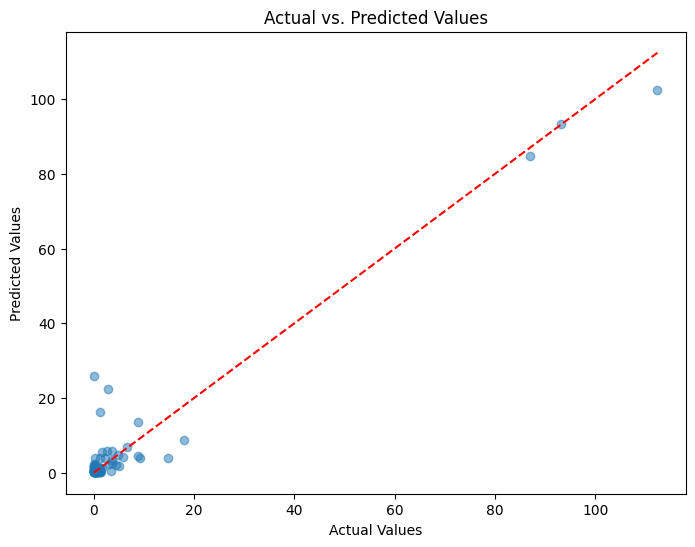

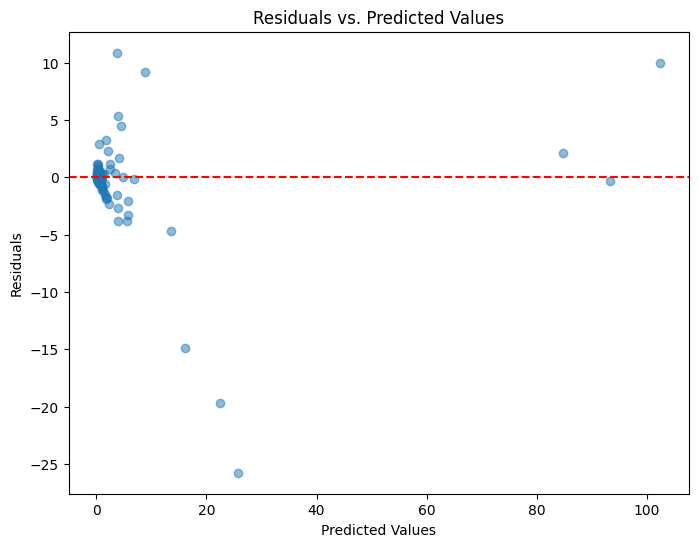

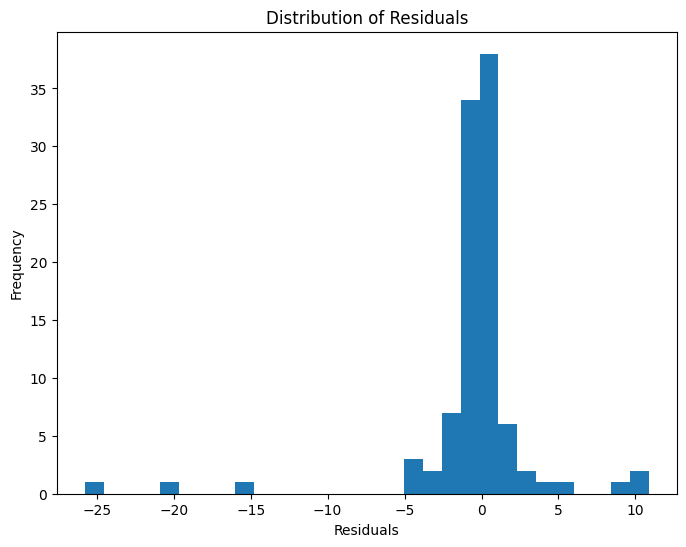

In [ ]:
# Plotting actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--') # Add a diagonal line
plt.show()


# Residual analysis
residuals = y_true - y_pred

# Plot residuals vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.show()

# Plot a histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Define the Transformer model
class TransformerRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_heads, dropout_rate=0.):
        super(TransformerRegressor, self).__init__()

        # Input embedding layer (optional for tabular data)
        #self.embedding = nn.Linear(input_size, hidden_size)

        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output layer for regression
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Input embedding (optional)
        #x = self.embedding(x)

        # Transformer encoding
        out = self.transformer_encoder(x.unsqueeze(0))  # Add batch dimension

        # Regression output
        out = self.fc(out.squeeze(0))  # Remove batch dimension
        return out

# Convert data to PyTorch tensors (same as before)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1), dtype=torch.float32)

# Create datasets and dataloaders (same as before)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Model parameters
input_size = X_train.shape[1]
hidden_size = 448
num_layers = 2
num_heads = 4
learning_rate = 5e-5
num_epochs = 100

# Initialize the model, loss function, and optimizer
model = TransformerRegressor(input_size, hidden_size, num_layers, num_heads)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    train_loss = 0.0  # Initialize train_loss for the epoch

    # For calculating R2 on training set
    all_train_targets = []
    all_train_outputs = []

    for i, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)  # Accumulate train_loss

        # Store predictions and targets for R2 calculation
        all_train_targets.extend(targets.detach().cpu().numpy().flatten())
        all_train_outputs.extend(outputs.detach().cpu().numpy().flatten())

    epoch_train_loss = train_loss / len(train_loader.dataset)  # Average train_loss

    # Calculate metrics on training set
    train_mae = mean_absolute_error(all_train_targets, all_train_outputs)
    train_rmse = np.sqrt(mean_squared_error(all_train_targets, all_train_outputs))
    train_r2 = r2_score(all_train_targets, all_train_outputs)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, '
          f'Train MAE: {train_mae:.4f}, '
          f'Train RMSE: {train_rmse:.4f}, '
          f'Train R2: {train_r2:.4f}', end=", ")

    # Validation calculation within the epoch loop
    with torch.no_grad():
        model.eval()
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        y_pred = val_outputs.detach().cpu().numpy()  # Convert to NumPy array
        y_true = y_val_tensor.cpu().numpy()  # Convert to NumPy array

        # Calculate metrics on validation set
        val_mae = mean_absolute_error(y_true, y_pred)
        val_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        val_r2 = r2_score(y_true, y_pred)

        print(f'Validation Loss: {val_loss.item():.4f}, '
              f'Validation MAE: {val_mae:.4f}, '
              f'Validation RMSE: {val_rmse:.4f}, '
              f'Validation R2: {val_r2:.4f}')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/100], Train Loss: 137.3420, Train MAE: 3.2089, Train RMSE: 11.7193, Train R2: 0.0446, Validation Loss: 251.2141, Validation MAE: 4.5437, Validation RMSE: 15.8497, Validation R2: 0.1013
Epoch [2/100], Train Loss: 123.5996, Train MAE: 3.1958, Train RMSE: 11.1175, Train R2: 0.1402, Validation Loss: 239.2091, Validation MAE: 4.3860, Validation RMSE: 15.4664, Validation R2: 0.1443
Epoch [3/100], Train Loss: 118.2396, Train MAE: 2.9518, Train RMSE: 10.8738, Train R2: 0.1775, Validation Loss: 233.0468, Validation MAE: 4.2799, Validation RMSE: 15.2659, Validation R2: 0.1663
Epoch [4/100], Train Loss: 115.5278, Train MAE: 2.7773, Train RMSE: 10.7484, Train R2: 0.1963, Validation Loss: 230.3505, Validation MAE: 4.1694, Validation RMSE: 15.1773, Validation R2: 0.1759
Epoch [5/100], Train Loss: 114.0176, Train MAE: 2.7002, Train RMSE: 10.6779, Train R2: 0.2068, Validation Loss: 228.7336, Validation MAE: 4.1047, Validation RMSE: 15.1239, Validation R2: 0.1817
Epoch [6/100], Train Loss: 113

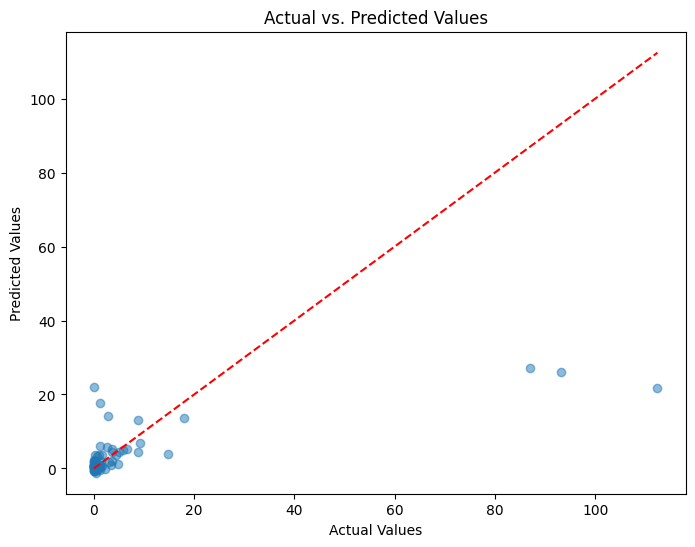

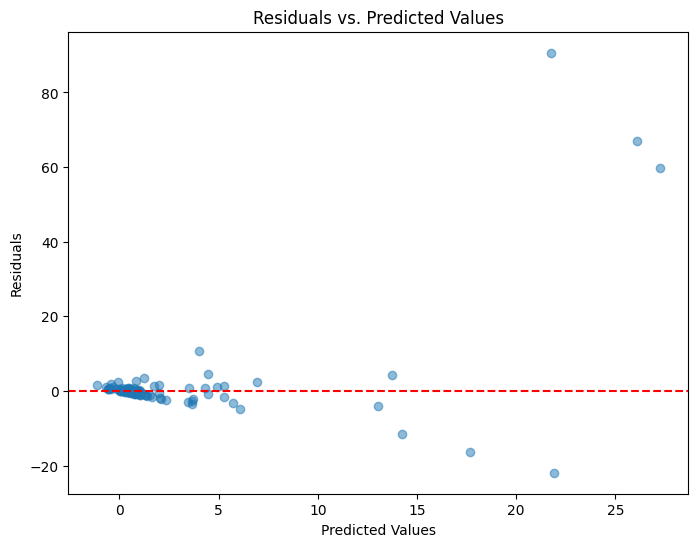

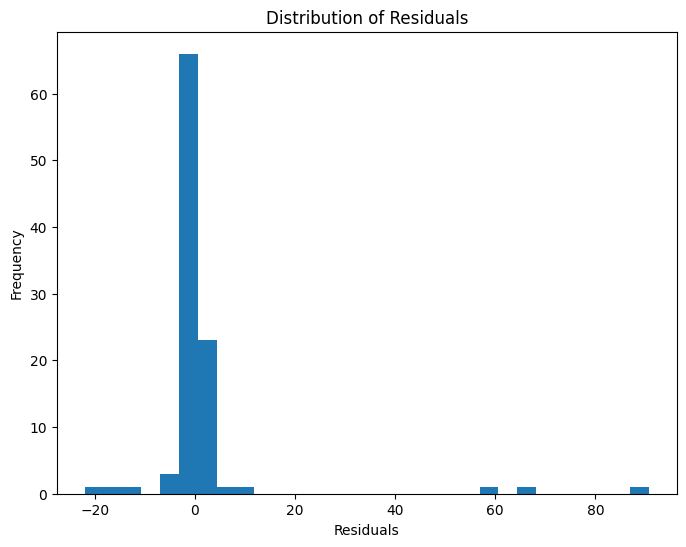

In [ ]:
# Plotting actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--') # Add a diagonal line
plt.show()


# Residual analysis
residuals = y_true - y_pred

# Plot residuals vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.show()

# Plot a histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()